# Leios simulation analysis at tag `leios-2025w29`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: stracciatella

In [2]:
label <- "Rust simulator, mini-mainnet, full-without-ibs"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/stracciatella/lifecycle.Rdata")) {
    load(file="results/stracciatella/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/stracciatella/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/stracciatella/lifecycle.R")
}
lifecycle[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
lifecycle %>% summary

 Simulator            Stage length      Max EB size    Kind       
 Rust:109296   5 slot/stage :54888   5.0 MB/EB:50706   EB:  1480  
               8 slot/stage :54408   2.0 MB/EB:34272   RB:   464  
               15 slot/stage:    0   1.0 MB/EB:15460   TX:107352  
                                     0.5 MB/EB: 8858              
                                     0.2 MB/EB:    0              
                                                                  
                                                                  
      Item           Size [B]       References      Created [s]    
 0      :     8   Min.   :   12   Min.   : 0.000   Min.   :  19.0  
 1      :     8   1st Qu.:  444   1st Qu.: 1.000   1st Qu.: 211.0  
 10     :     8   Median :  954   Median : 1.000   Median : 361.4  
 100    :     8   Mean   : 1957   Mean   : 1.997   Mean   : 364.4  
 1000   :     8   3rd Qu.: 2056   3rd Qu.: 2.000   3rd Qu.: 513.0  
 1001   :     8   Max.   :98303   Max.   :66.000   Max. 

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

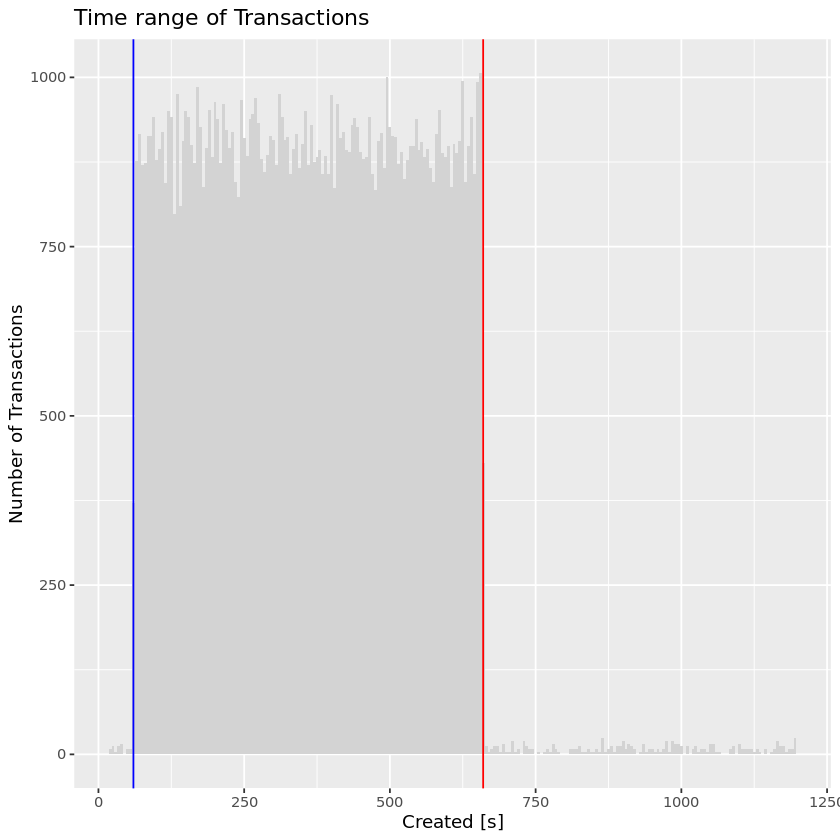

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [Mb/s]`=8*sum(`Size [B]`)/1e6/txWindow,
        `Time to full EB [s]`=1/(sum(`Size [B]`)/(1e6*as.numeric(substring(`Max EB size`, 1, 4)))/txWindow),
        `Transaction size [B/tx]`=sum(`Size [B]`)/.N
    ),
    .(`Stage length`, `Max EB size`)
][order(`Stage length`, - `Max EB size`)]

Stage length,Max EB size,Demand [tx/s],Demand [MB/s],Demand [Mb/s],Time to full EB [s],Transaction size [B/tx]
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5 slot/stage,0.5 MB/EB,6.976667,0.01183958,0.09471661,42.23124,1697.025
5 slot/stage,1.0 MB/EB,12.478333,0.02129649,0.17037196,46.95608,1706.678
5 slot/stage,2.0 MB/EB,28.155000,0.04781171,0.38249368,41.83076,1698.161
5 slot/stage,5.0 MB/EB,41.850000,0.07115336,0.56922689,70.27075,1700.200
8 slot/stage,0.5 MB/EB,6.976667,0.01183958,0.09471661,42.23124,1697.025
8 slot/stage,1.0 MB/EB,12.478333,0.02129649,0.17037196,46.95608,1706.678
8 slot/stage,2.0 MB/EB,28.155000,0.04781171,0.38249368,41.83076,1698.161
8 slot/stage,5.0 MB/EB,41.850000,0.07115336,0.56922689,70.27075,1700.200


#### Size of persisted data

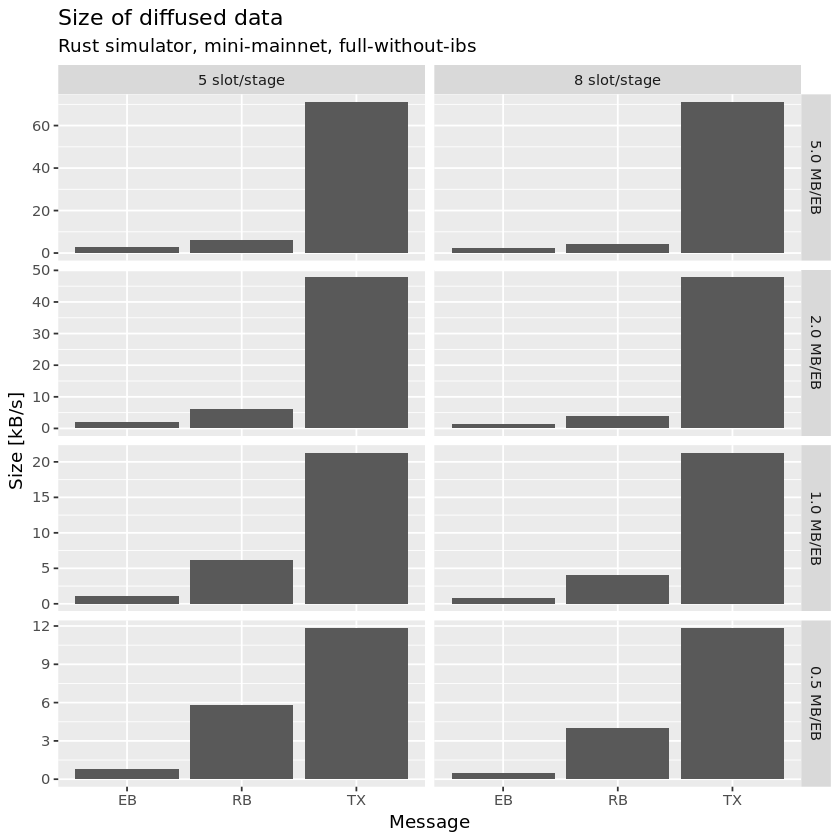

In [7]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Message`=`Kind`, `Stage length`, `Max EB size`)
    ],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ggtitle("Size of diffused data", subtitle=label)

In [8]:
ggsave("plots/stracciatella/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/stracciatella/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [10]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Stage length`, `Max EB size`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Kind` != "VT") * `Size [B]`))), 
            .(`Stage length`, `Max EB size`)
        ],
        on=c("Stage length", "Max EB size")
    ][, .(`Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)][order(`Stage length`, -`Max EB size`)]

Stage length,Max EB size,Space efficiency [%]
<fct>,<fct>,<dbl>
5 slot/stage,0.5 MB/EB,64.13165
5 slot/stage,1.0 MB/EB,74.57606
5 slot/stage,2.0 MB/EB,85.38662
5 slot/stage,5.0 MB/EB,88.69461
8 slot/stage,0.5 MB/EB,72.36576
8 slot/stage,1.0 MB/EB,81.66809
8 slot/stage,2.0 MB/EB,89.55633
8 slot/stage,5.0 MB/EB,91.91031


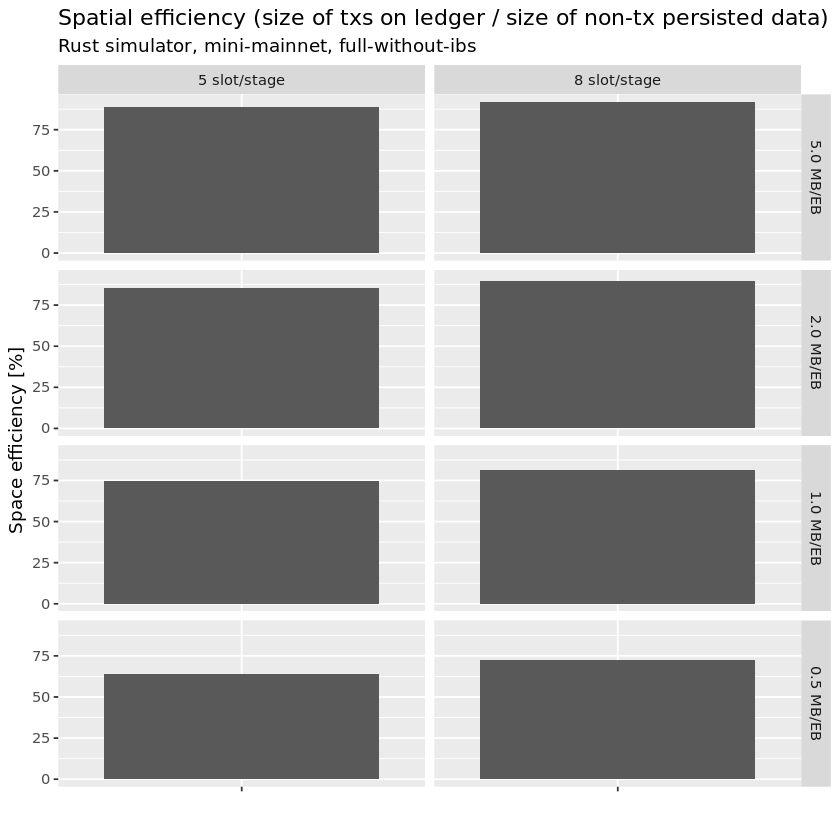

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Stage length`, `Max EB size`)
    ][
        lifecycle[
            `Kind` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Kind` != "VT") * `Size [B]`))), 
            .(`Stage length`, `Max EB size`)
        ],
        on=c("Stage length", "Max EB size")
    ][, .(`Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x="", y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [12]:
ggsave("plots/stracciatella/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("plots/stracciatella/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the EB

In [14]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        .(`Stage length`, `Max EB size`)
    ][order(`Stage length`, -`Max EB size`)]

Stage length,Max EB size,Time to reach EB [s]
<fct>,<fct>,<dbl>
5 slot/stage,0.5 MB/EB,5.870323
5 slot/stage,1.0 MB/EB,5.846619
5 slot/stage,2.0 MB/EB,5.846295
5 slot/stage,5.0 MB/EB,5.821703
8 slot/stage,0.5 MB/EB,9.320229
8 slot/stage,1.0 MB/EB,9.779036
8 slot/stage,2.0 MB/EB,10.036648
8 slot/stage,5.0 MB/EB,9.902443


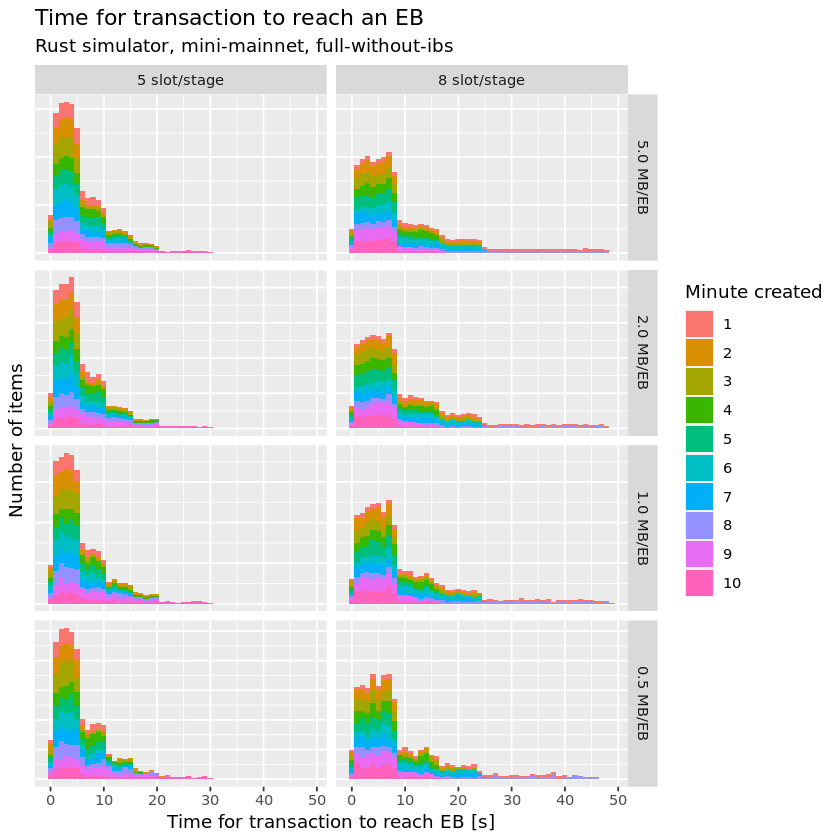

In [15]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
        .(`Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [16]:
ggsave("plots/stracciatella/reach-eb-tx.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/stracciatella/reach-eb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

In [18]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`Stage length`, `Max EB size`)
    ]

Stage length,Max EB size,Time to reach ledger [s]
<fct>,<fct>,<dbl>
5 slot/stage,1.0 MB/EB,66.97207
5 slot/stage,2.0 MB/EB,69.78167
5 slot/stage,0.5 MB/EB,66.82399
5 slot/stage,5.0 MB/EB,70.43894
8 slot/stage,1.0 MB/EB,59.93600
8 slot/stage,2.0 MB/EB,60.64178
8 slot/stage,0.5 MB/EB,60.07737
8 slot/stage,5.0 MB/EB,60.36516


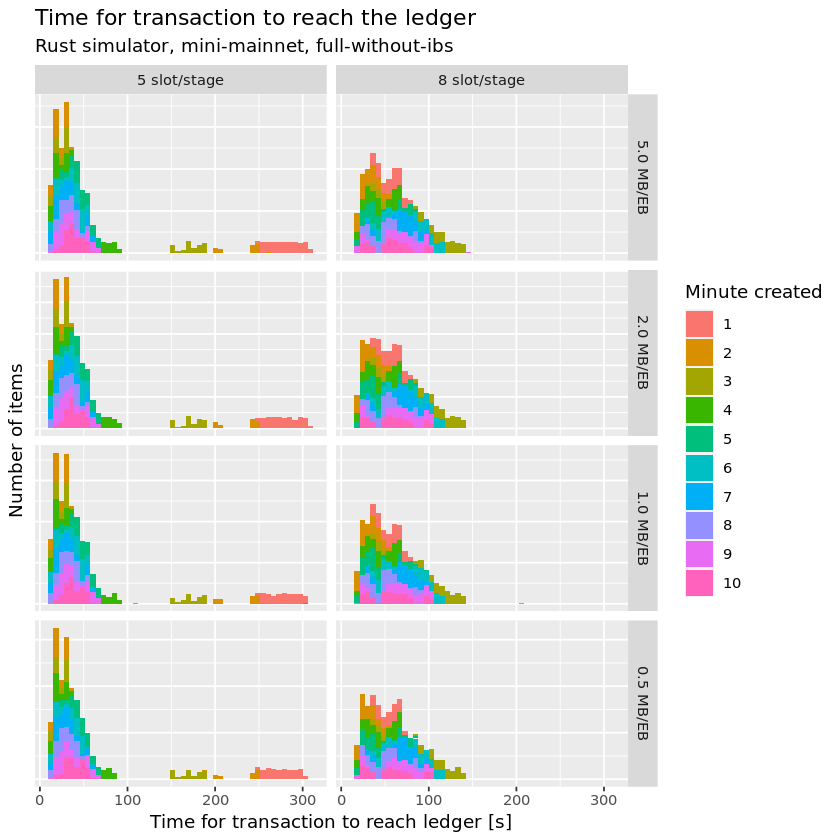

In [19]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [20]:
ggsave("plots/stracciatella/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [21]:
ggsave("plots/stracciatella/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

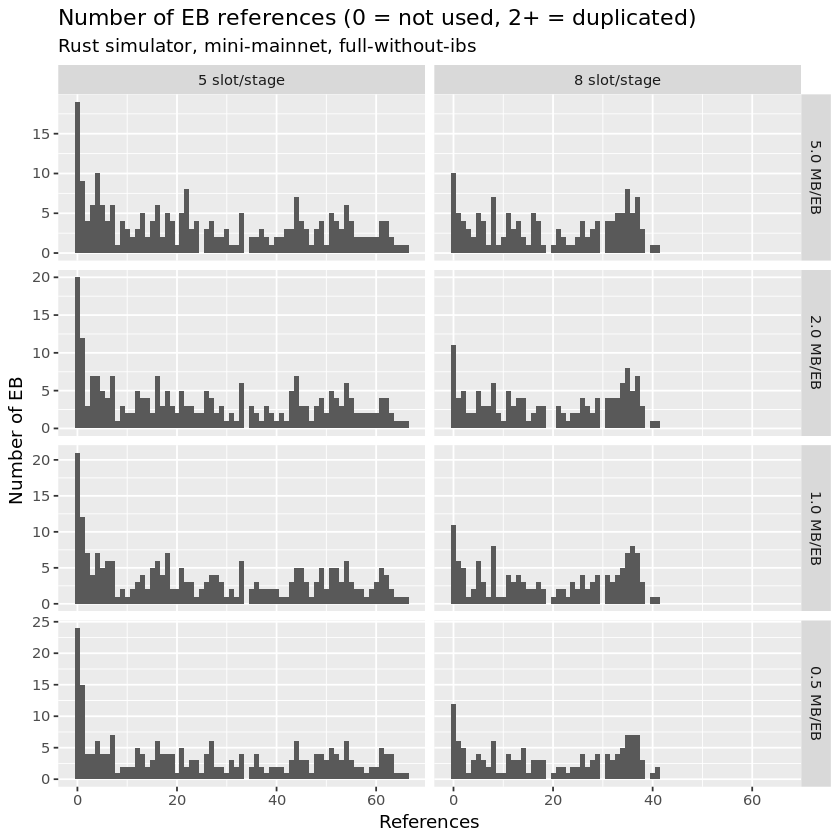

In [22]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [23]:
ggsave("plots/stracciatella/references-tx.png", units="in", dpi=150, width=8, height=6)

In [24]:
ggsave("plots/stracciatella/references-tx.svg", units="in", dpi=150, width=8, height=6)

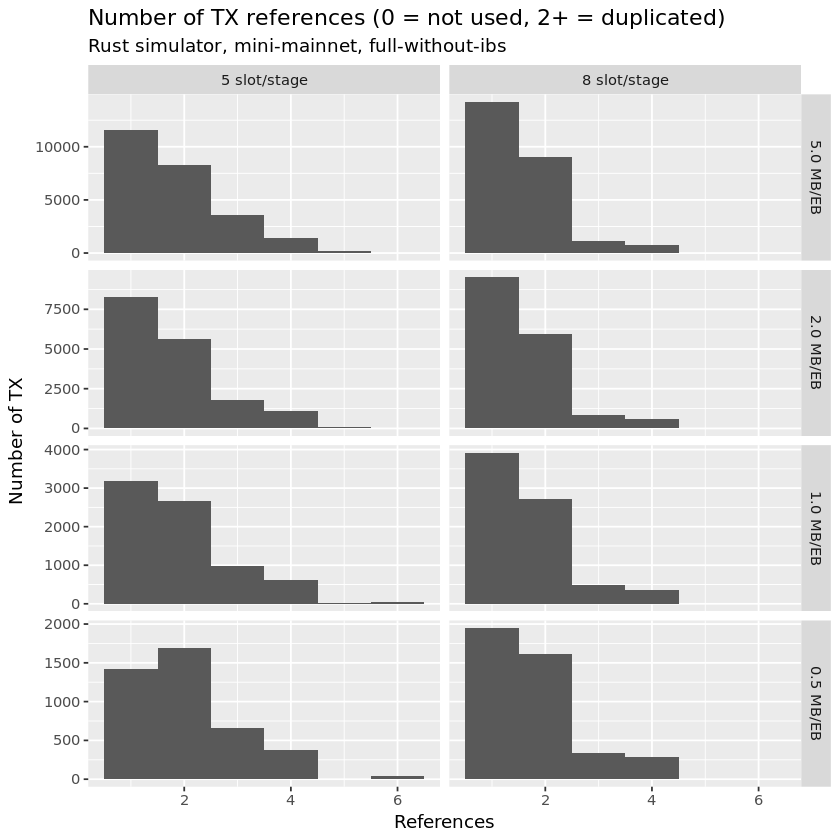

In [25]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [26]:
ggsave("plots/stracciatella/references-tx.png", units="in", dpi=150, width=8, height=6)

In [27]:
ggsave("plots/stracciatella/references-tx.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [28]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [29]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Stage length`, `Max EB size`
    )
][order(`Stage length`, `Max EB size`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [30]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Stage length`, `Max EB size`, `Submitted [minute]`)]

#### Transactions reaching the ledger

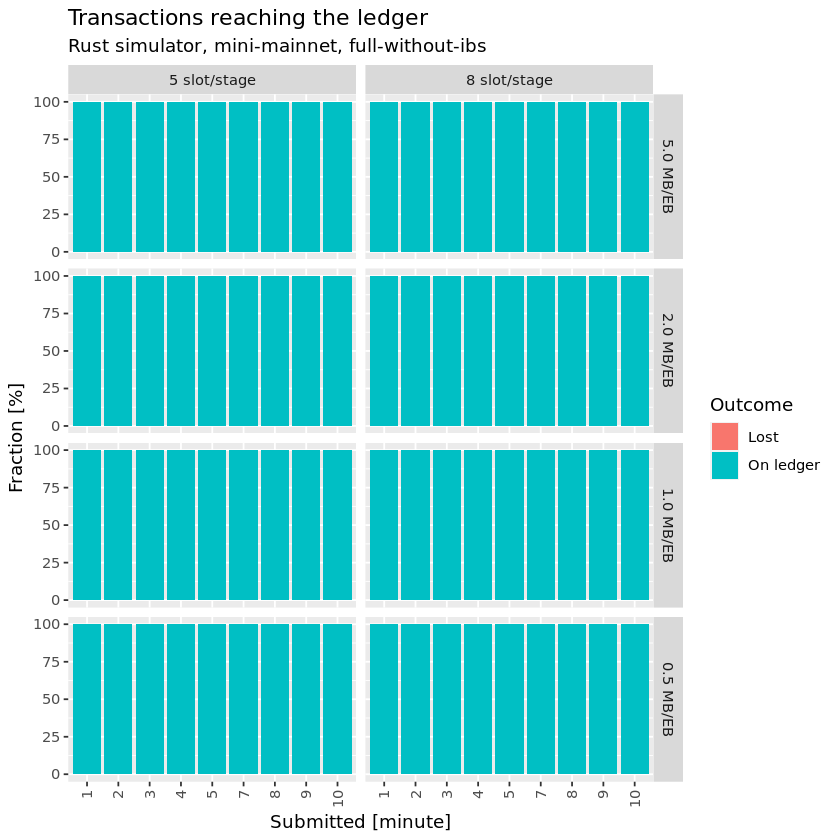

In [31]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Stage length`, `Max EB size`, `Submitted [minute]`)],
        id.vars=c("Stage length", "Max EB size", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `Stage length`, 
        `Max EB size`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [32]:
ggsave("plots/stracciatella/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [33]:
ggsave("plots/stracciatella/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

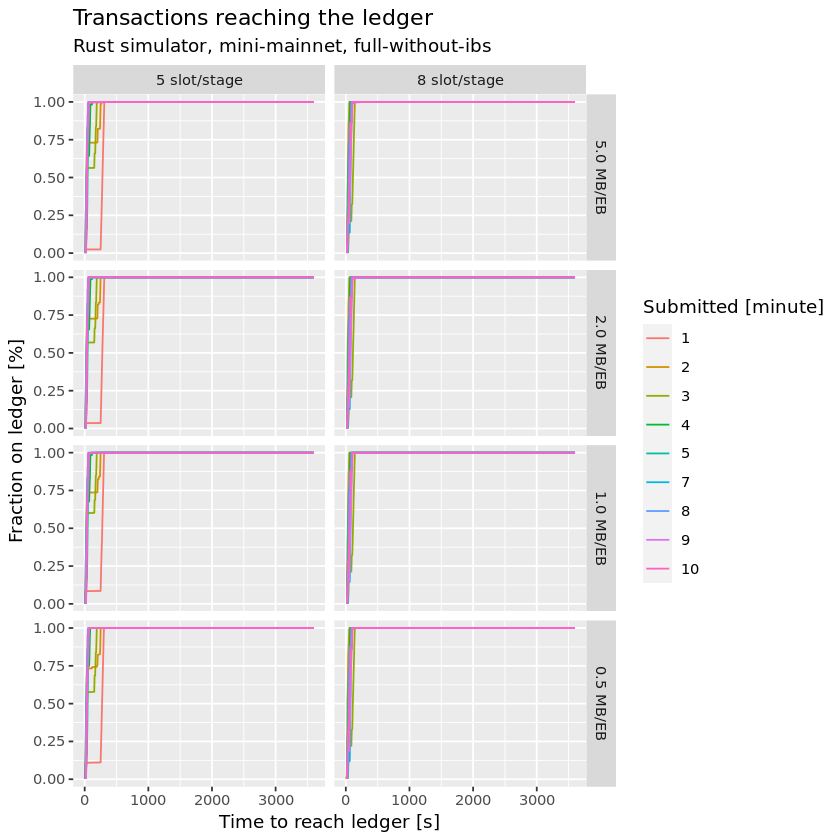

In [34]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`Stage length`, `Max EB size`, `Submitted [minute]`)
            ],
            on=c("Stage length", "Max EB size", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Stage length`, `Max EB size`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Stage length`, `Max EB size`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Max EB size` ~ `Stage length`) +
    ggtitle("Transactions reaching the ledger", label)

In [35]:
ggsave("plots/stracciatella/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [36]:
ggsave("plots/stracciatella/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [37]:
rm(lifecycle, outcomes, totals)

In [38]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1022306,54.6,2283332,122.0,2283332,122.0
Vcells,2205119,16.9,8486876,64.8,8486876,64.8


### Resource usage

In [39]:
if (file.exists("results/stracciatella/resources.Rdata")) {
    load(file="results/stracciatella/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/stracciatella/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/stracciatella/resources.Rdata")
}
resources[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
resources %>% summary

 Simulator          Stage length     Max EB size         Node     
 Rust:6000   5 slot/stage :3000   5.0 MB/EB:1500   node-0  :   8  
             8 slot/stage :3000   2.0 MB/EB:1500   node-1  :   8  
             15 slot/stage:   0   1.0 MB/EB:1500   node-10 :   8  
                                  0.5 MB/EB:1500   node-100:   8  
                                  0.2 MB/EB:   0   node-101:   8  
                                                   node-102:   8  
                                                   (Other) :5952  
   Egress [B]           Disk [B]      Total CPU [s]   Maximum CPU [s/s]
 Min.   :    23310   Min.   :     0   Min.   :38.85   Min.   :0.5637   
 1st Qu.:  1788634   1st Qu.:     0   1st Qu.:51.99   1st Qu.:0.9278   
 Median : 15792460   Median :     0   Median :63.23   Median :1.0917   
 Mean   : 29462798   Mean   :  5227   Mean   :63.95   Mean   :1.4722   
 3rd Qu.: 38196004   3rd Qu.:     0   3rd Qu.:70.60   3rd Qu.:1.8123   
 Max.   :322027863   Max.   :212

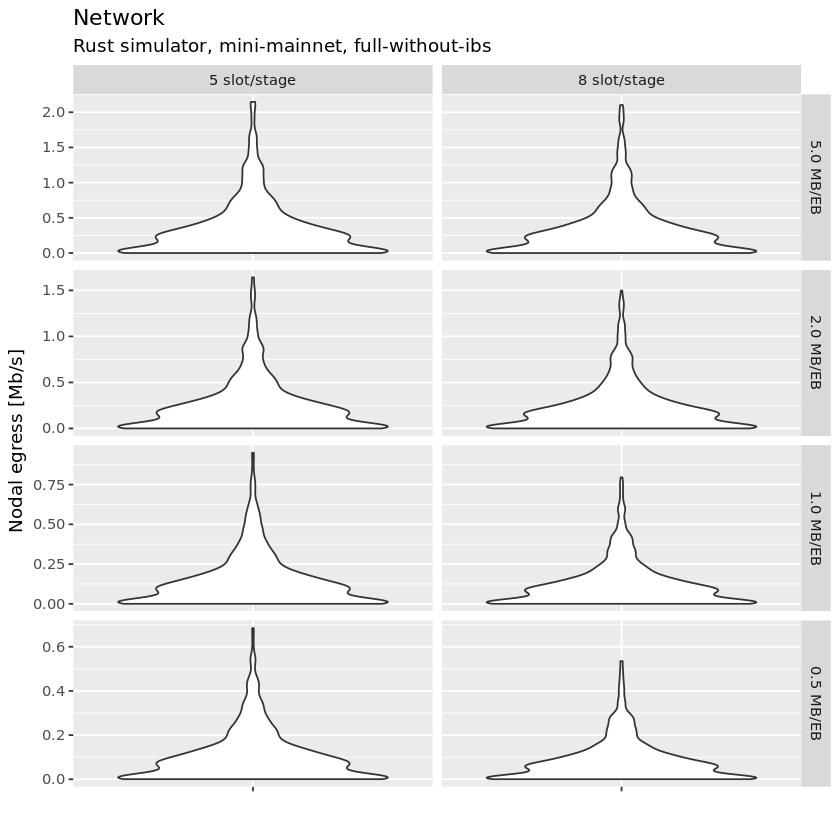

In [40]:
ggplot(
    resources[, .(`Stage length`, `Max EB size`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [41]:
ggsave("plots/stracciatella/network.png", units="in", dpi=150, width=9.5, height=5.5)

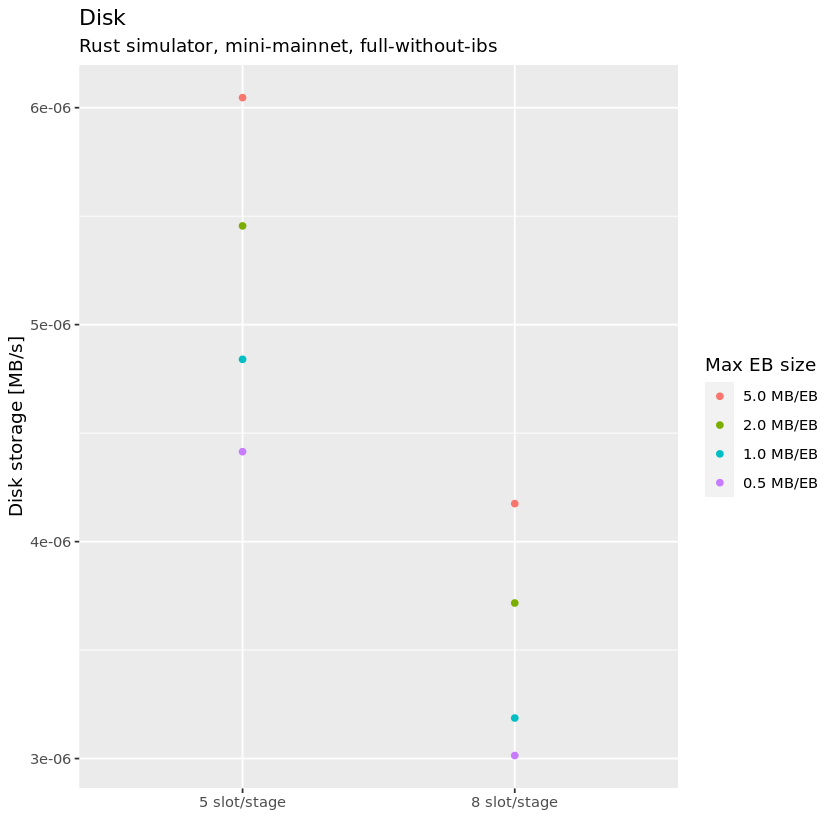

In [42]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Stage length`, `Max EB size`)],
    aes(x=`Stage length`, color=`Max EB size`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    ggtitle("Disk", label)

In [43]:
ggsave("plots/stracciatella/disk.png", units="in", dpi=150, width=9.5, height=5.5)

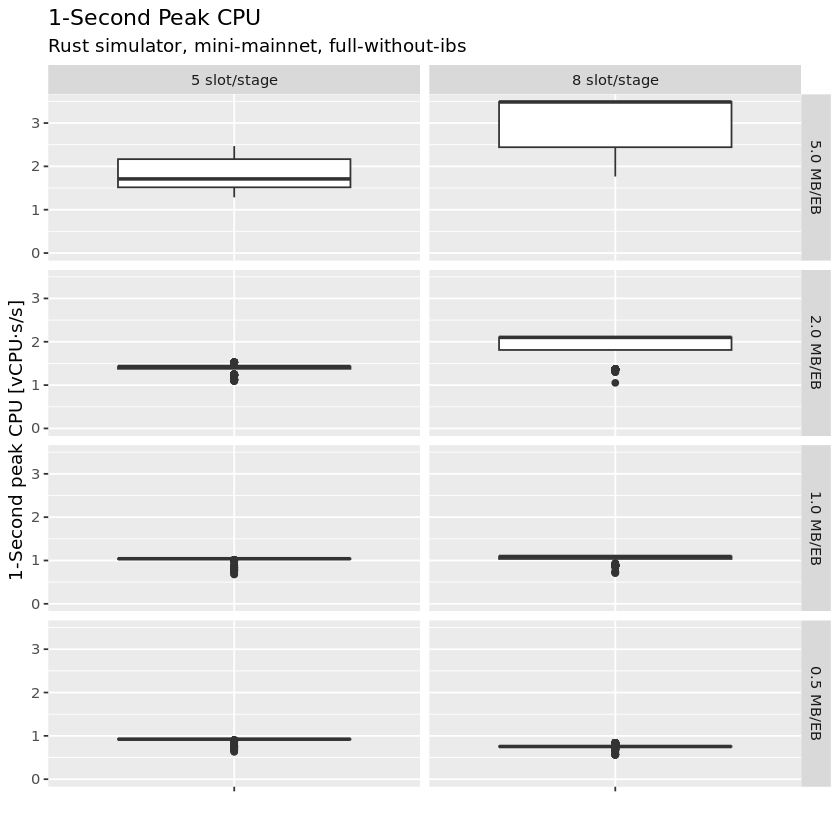

In [44]:
ggplot(
    resources[, .(`Node`, `Stage length`, `Max EB size`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [45]:
ggsave("plots/stracciatella/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

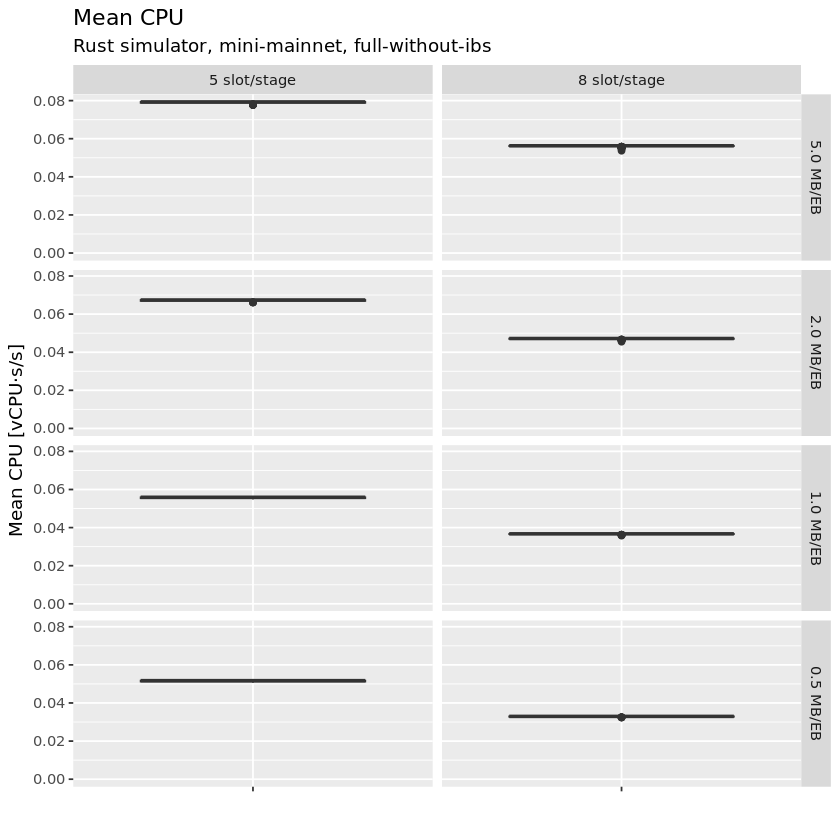

In [46]:
ggplot(
    resources[, .(`Stage length`, `Max EB size`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [47]:
ggsave("plots/stracciatella/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [48]:
rm(resources)

In [49]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1052423,56.3,2283332,122.0,2283332,122.0
Vcells,1928216,14.8,8486876,64.8,8486876,64.8


### Receipt of messages

#### Read results

In [50]:
if (file.exists("results/stracciatella/receipts.Rdata")) {
    load("results/stracciatella/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/stracciatella/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/stracciatella/receipts.Rdata")
}
receipts[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
receipts %>% summary

 Simulator               Stage length          Max EB size       Kind          
 Rust:220325001   5 slot/stage :124834234   5.0 MB/EB:72594368   EB:  1108520  
                  8 slot/stage : 95490767   2.0 MB/EB:60285303   RB:   343701  
                  15 slot/stage:        0   1.0 MB/EB:46195115   TX: 80406648  
                                            0.5 MB/EB:41250215   VT:138466132  
                                            0.2 MB/EB:       0                 
                                                                               
                                                                               
            Item               Producer         Generated [s]   
 1000-node-136:     8988   node-525:   710052   Min.   :  19.0  
 1000-node-574:     8988   node-60 :   707056   1st Qu.: 256.0  
 1000-node-608:     8988   node-529:   704060   Median : 475.0  
 1120-node-134:     8988   node-566:   704060   Mean   : 521.1  
 1120-node-497:     8988   node-97 

In [51]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [52]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Stage length`, `Max EB size`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

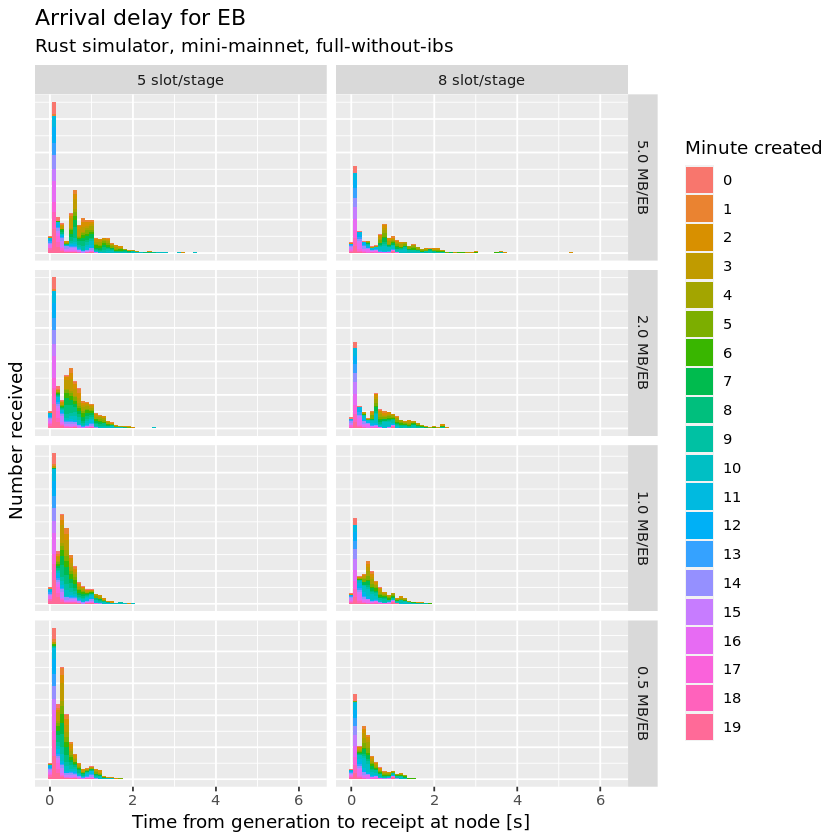

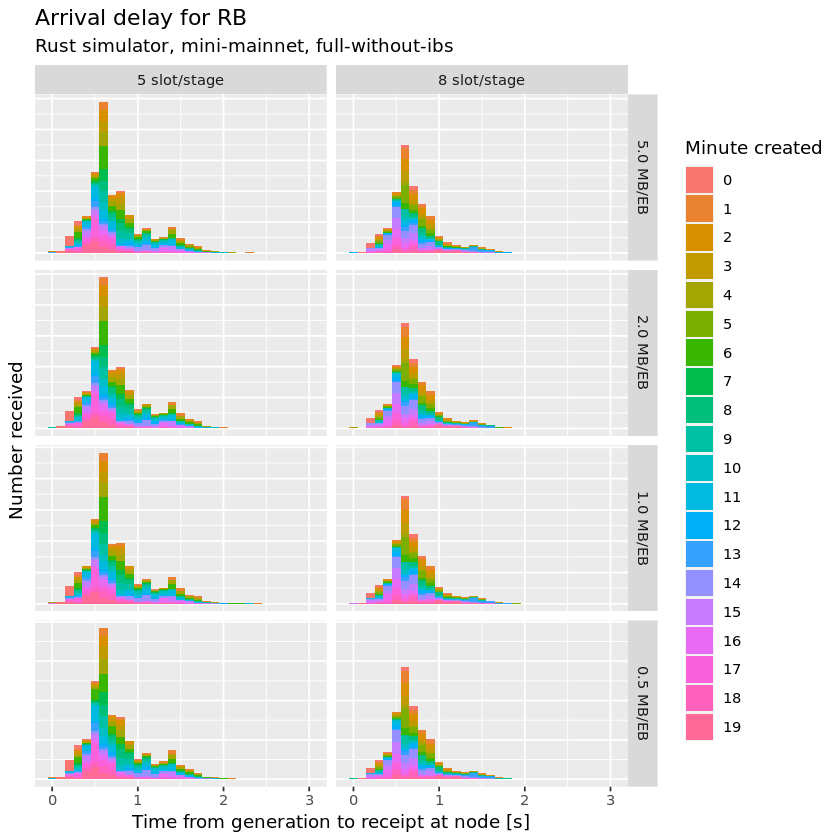

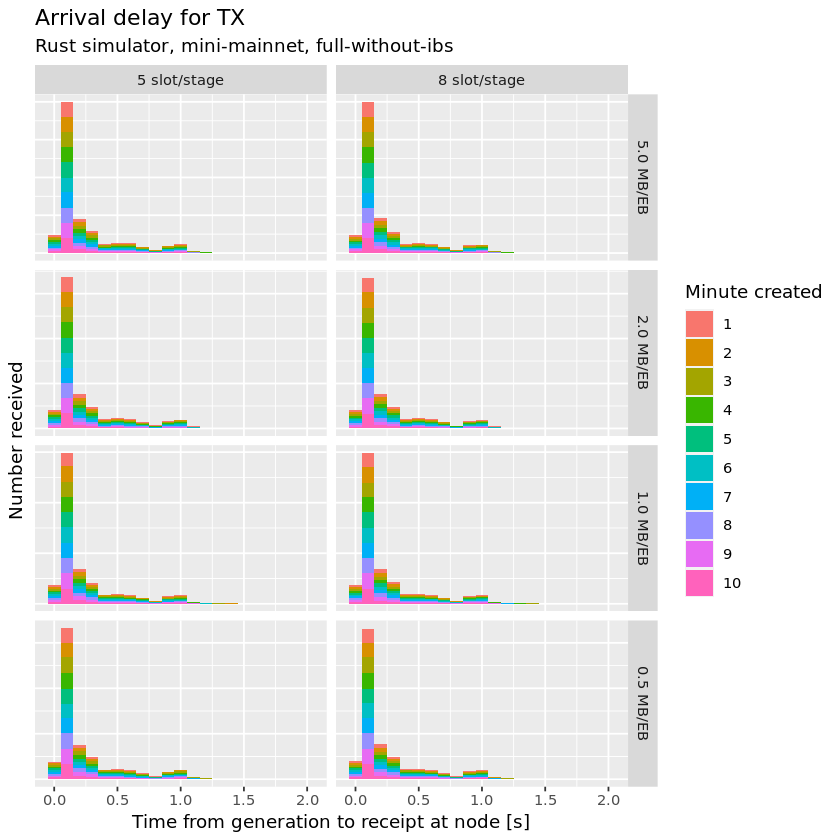

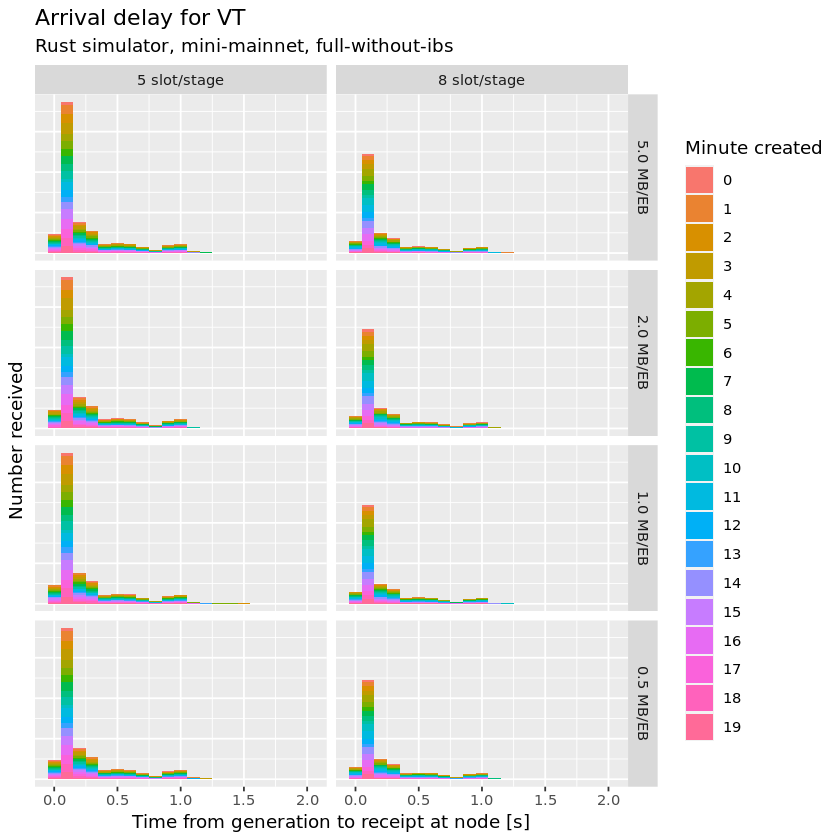

In [53]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/stracciatella/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [54]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

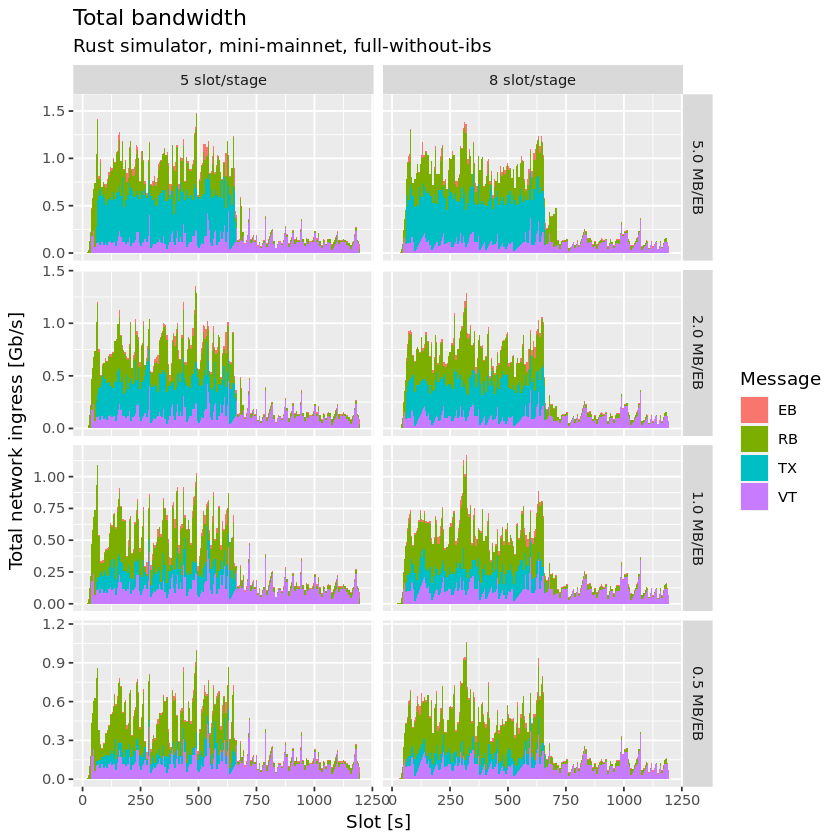

In [55]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/stracciatella/ingress-total-area.png")
)

##### Bandwidth usage per node

In [56]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [57]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

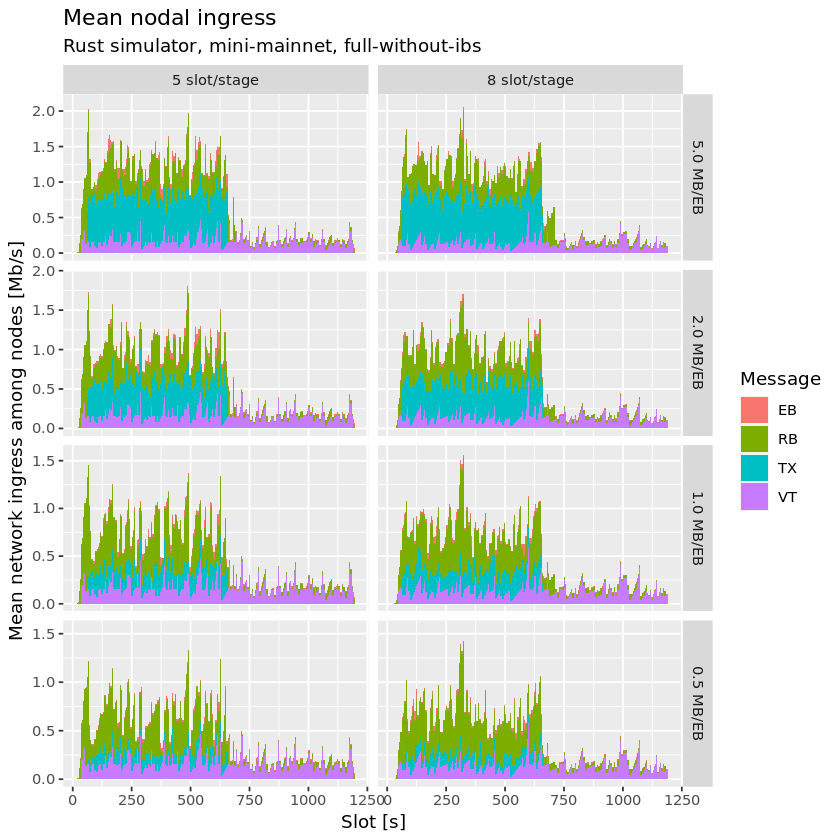

In [58]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/stracciatella/ingress-average-area.png")
)

In [59]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Stage length`, `Max EB size`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

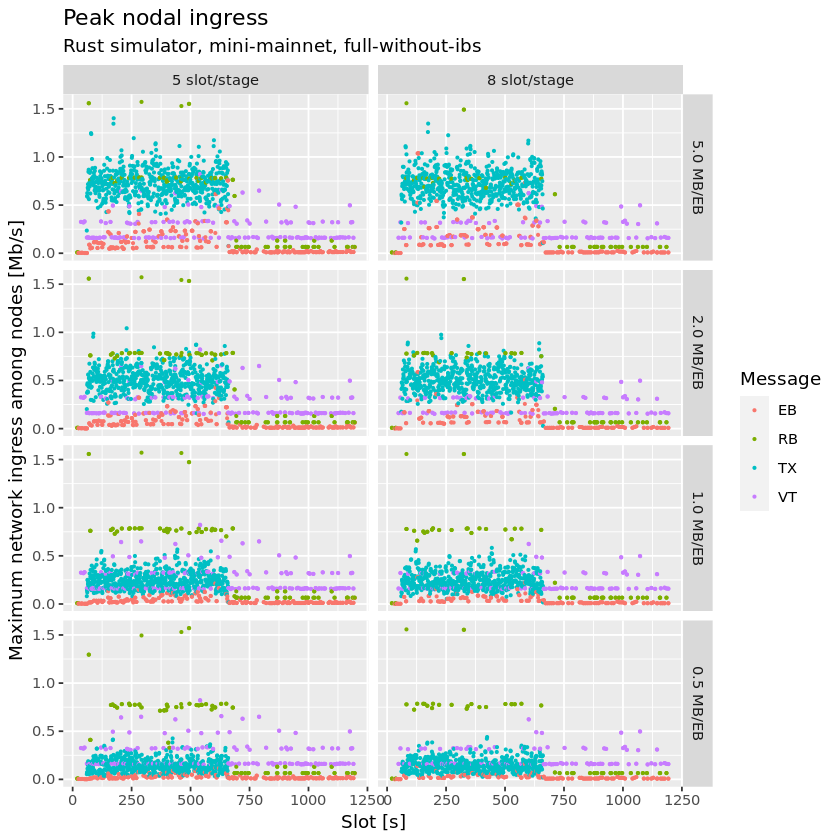

In [60]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/stracciatella/ingress-peak-point.png")
)

#### Release memory

In [61]:
rm(receipts)

In [62]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1134105,60.6,2283332,122.0,2283332,122.0
Vcells,1740816962,13281.4,5541887604,42281.3,5541887604,42281.3


### CPU usage

#### Read results

In [63]:
if (file.exists("results/stracciatella/cpus.Rdata")) {
    load(file="results/stracciatella/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/stracciatella/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/stracciatella/cpus.Rdata")
}
cpus[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
cpus %>% summary

 Simulator               Stage length          Max EB size      
 Rust:291584834   5 slot/stage :173571251   5.0 MB/EB:90409333  
                  8 slot/stage :118013583   2.0 MB/EB:78100264  
                  15 slot/stage:        0   1.0 MB/EB:64010069  
                                            0.5 MB/EB:59065168  
                                            0.2 MB/EB:       0  
                                                                
                                                                
      Slot              Node                Task            Duration [s]     
 Min.   :  19.0   node-222:   388928   GenEB  :     1480   Min.   :0.000065  
 1st Qu.: 275.0   node-100:   388924   GenRB  :      464   1st Qu.:0.000065  
 Median : 496.0   node-151:   388924   GenVote:   279653   Median :0.000816  
 Mean   : 537.6   node-16 :   388924   ValEB  :  1108520   Mean   :0.001316  
 3rd Qu.: 752.0   node-166:   388924   ValRB  :   343701   3rd Qu.:0.000816  
 Max.   :120

In [64]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Stage length`, `Max EB size`, `Node`, `Slot`)
]

In [65]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [66]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

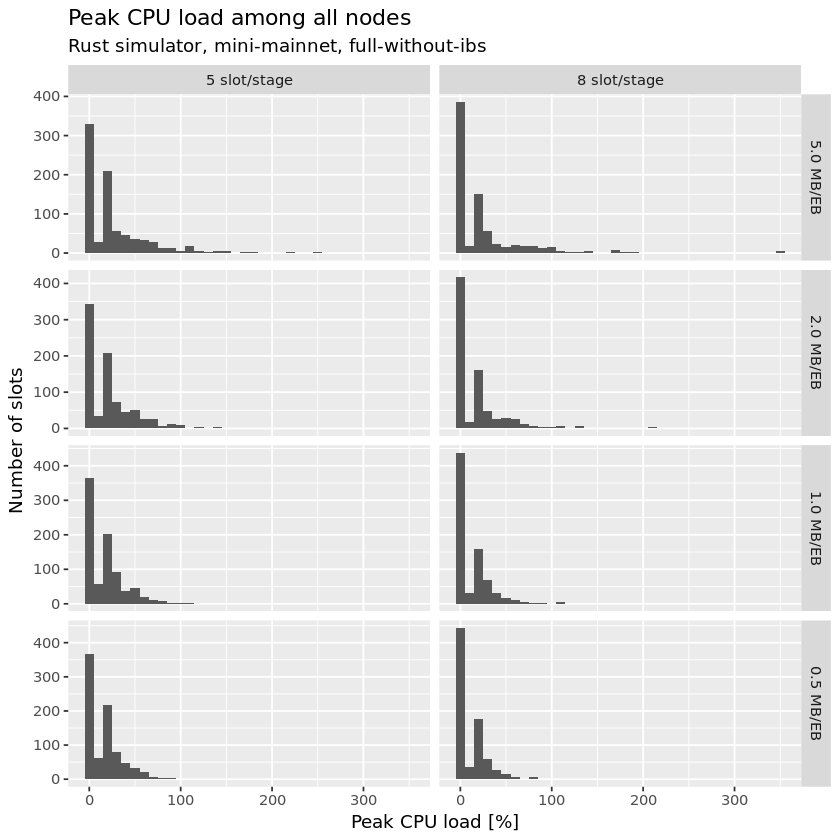

In [67]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/stracciatella/cpu-peak-histogram.png")
)

##### Time series

In [68]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Max EB size` ~ `Stage length`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

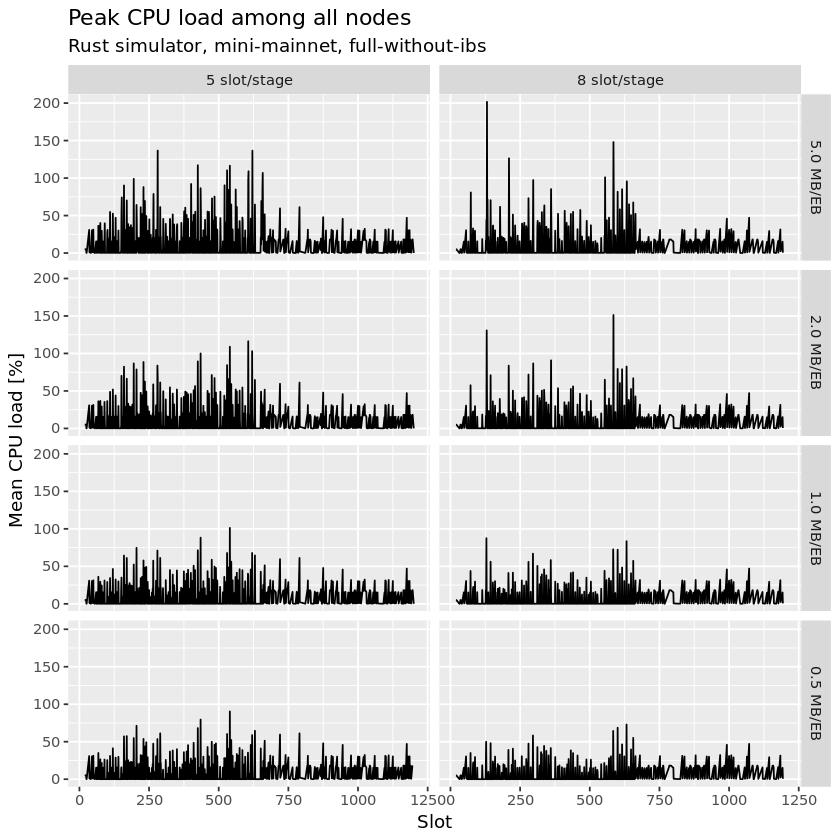

In [69]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/stracciatella/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [70]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `Max EB size`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

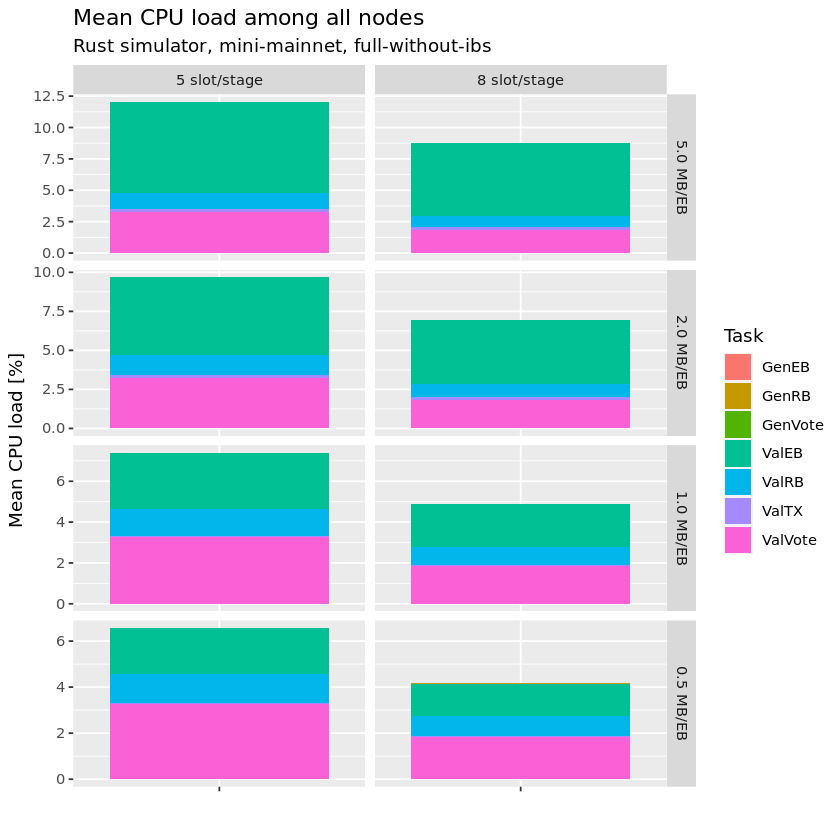

In [71]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/stracciatella/cpu-mean-histogram.png")
)

##### Time series

In [72]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `Max EB size`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

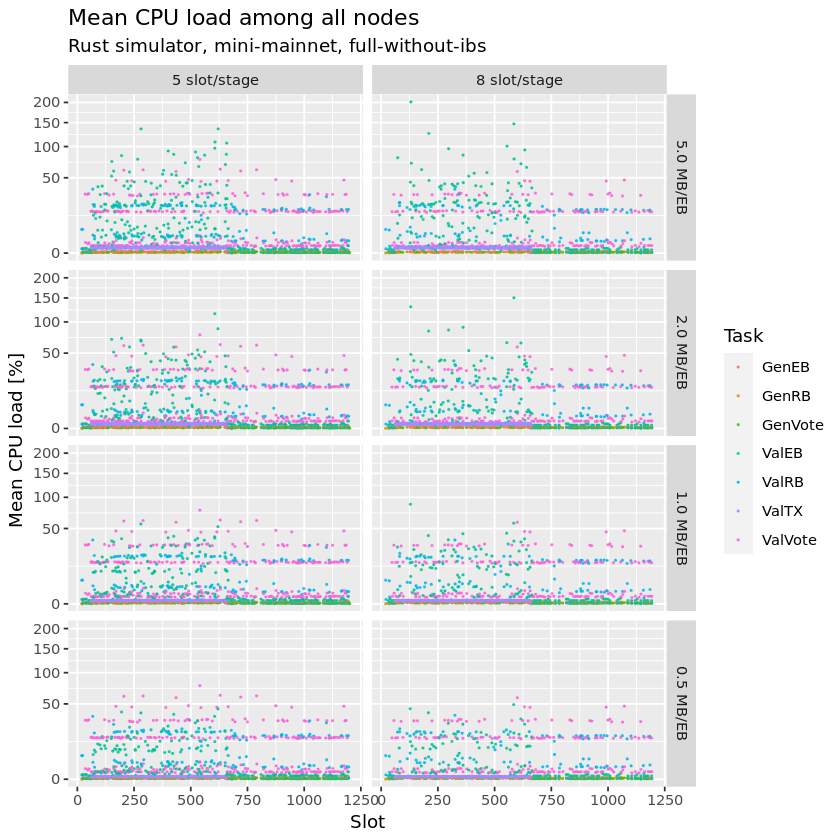

In [73]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/stracciatella/cpu-mean-timeseries.png")
)

#### Release memory

In [74]:
rm(cpus, cpusNode)

In [75]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1067791,57.1,2283332,122,2283332,122.0
Vcells,1210504341,9235.5,4433510084,33825,5541887604,42281.3
